In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )

loaded gammapy version: 1.0 
Supposed to be 1.0 (21-12-2022)


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit, Parameter, Parameters, Covariance
from gammapy.datasets import MapDataset #, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    ExpCutoffPowerLawSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

from Dataset_Creation import sys_dataset

## Read dataset

spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : 1MUXqVCD 

  Total counts                    : 361332 
  Total background counts         : 360331.31
  Total excess counts             : 1001.66

  Predicted counts                : 361332.98
  Predicted background counts     : 360331.34
  Predicted excess counts         : 1001.63

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -753578.91

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 7

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model typ

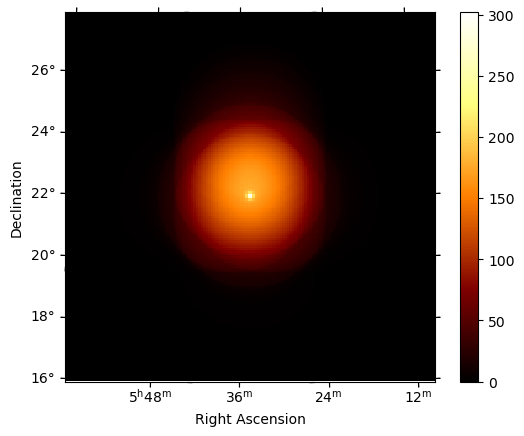

In [3]:
dataset_asimov = MapDataset.read("c:/users/yt02izug/downloads/dataset_asimov/dataset_asimov.fits")
# Create the spatial model 
model_spatial = GaussianSpatialModel(
    lon_0="83.631 deg",
    lat_0="22.018 deg",
    sigma="0.02 deg",
    )

# Create the spectral model 
model_spectrum  = PowerLawSpectralModel(#ExpCutoffPowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",
    #lambda_="0.1 TeV-1"
)

# combine the spectral and the spatial model
source_model = SkyModel(spatial_model = model_spatial ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models(source_model)

# Create the model for the Background
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)

# set the models in the dataset
dataset_asimov.models = models
# set counts
dataset_asimov.counts = dataset_asimov.npred()
    
dataset_asimov.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_asimov.geoms["geom"].width[1] / dataset_asimov.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)

print(dataset_asimov)

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy_true']
	shape : (23, 23, 24)
	ndim  : 3
	unit  : 1 / (cm2 s)
	dtype : float64



<WCSAxesSubplot: >

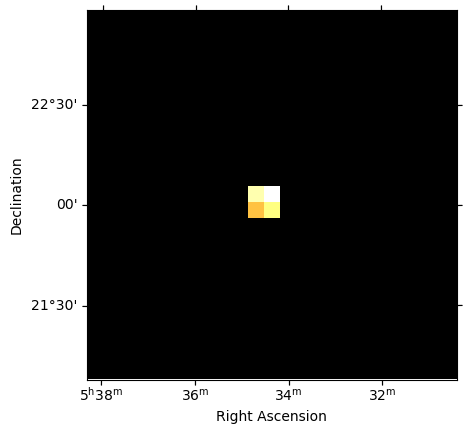

In [4]:
flux = dataset_asimov.evaluators['Source'].compute_flux()
print(flux)
flux.slice_by_idx(dict(energy_true = slice(10,11))).plot()

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy_true']
	shape : (23, 23, 24)
	ndim  : 3
	unit  : 
	dtype : float64



<WCSAxesSubplot: >

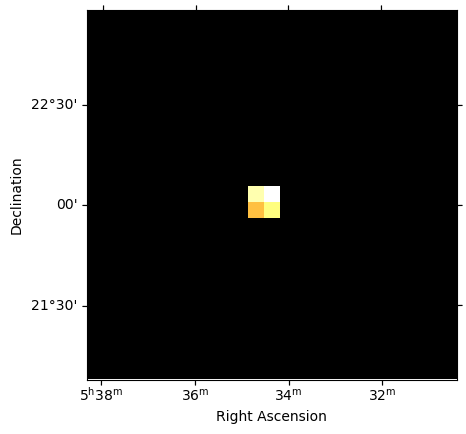

In [5]:
npred = dataset_asimov.evaluators['Source'].apply_exposure(flux)
print(npred)
npred.slice_by_idx(dict(energy_true = slice(10,11))).plot()

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (23, 23, 24)
	ndim  : 3
	unit  : 
	dtype : float64



<WCSAxesSubplot: >

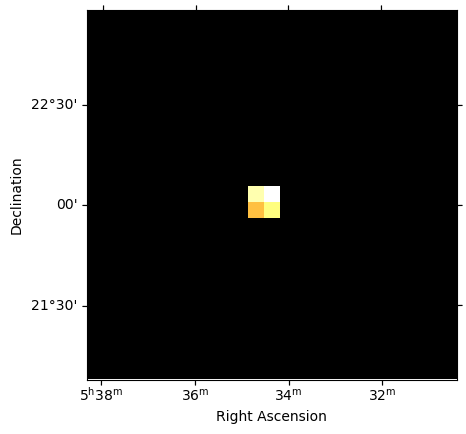

In [6]:
npred_reco = dataset_asimov.evaluators['Source'].apply_edisp(npred)
print(npred_reco)
npred_reco.slice_by_idx(dict(energy = slice(10,11))).plot()

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (23, 23, 24)
	ndim  : 3
	unit  : 
	dtype : float32



<WCSAxesSubplot: >

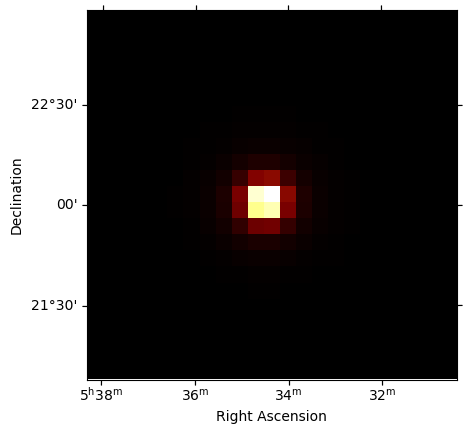

In [7]:
npred_reco_con = dataset_asimov.evaluators['Source'].apply_psf(npred_reco)
print(npred_reco_con)
npred_reco_con.slice_by_idx(dict(energy = slice(10,11))).plot()

## Varying the Exposure

In [8]:
true_energy = dataset_asimov.exposure.geom.axes[0].center.value

# energy independent method: pm 10% for reconstructed energy
shift_neg = -0.085
shift_pos = 0.085
shift_cor = 0.0

tilt_neg = -0.0 # -0.015 # 1e-25 for computational purposes -> covmatrix "1/0"
tilt_pos = -0.055 # 0.015
tilt_cor = 0.0

In [9]:
def sum_e(x):
    return x.sum(axis=2).sum(axis=1)

In [10]:
sys_d_cor = sys_dataset(dataset_asimov, shift_cor, tilt_cor, False)
dataset_cor = sys_d_cor.create_dataset()

sys_d_neg = sys_dataset(dataset_asimov, shift_neg, tilt_neg, False)
dataset_neg = sys_d_neg.create_dataset()

sys_d_pos = sys_dataset(dataset_asimov, shift_pos, tilt_pos, False)
dataset_pos = sys_d_pos.create_dataset()

#print(dataset_cor)

In [11]:
exposure_pos = dataset_pos.exposure
exposure_neg = dataset_neg.exposure

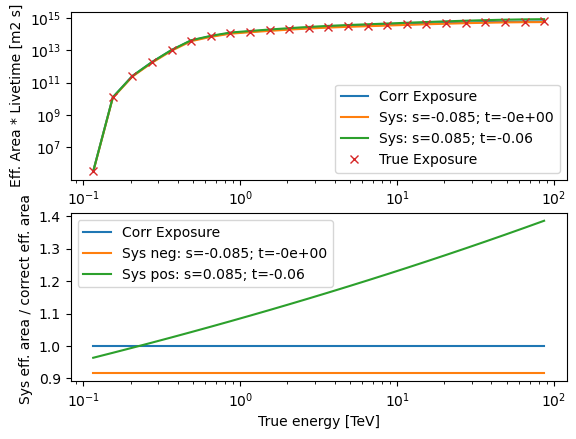

In [33]:
fig,ax = plt.subplots(2,1)

exposure_standard = dataset_asimov.exposure.data.sum(axis=2).sum(axis=1)
exposure_e = dataset_cor.exposure.data.sum(axis=2).sum(axis=1)

ax[0].plot(true_energy, exposure_e, label = "Corr Exposure")
ax[0].plot(true_energy, sum_e(exposure_neg.data), 
           label = f'Sys: s={shift_neg:.2}; t={tilt_neg:.1}')
ax[0].plot(true_energy, sum_e(exposure_pos.data), 
           label = f'Sys: s={shift_pos:.2}; t={tilt_pos:.1}')
ax[0].plot(true_energy, exposure_standard, 'x', label = "True Exposure")

ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_xlabel("True energy [TeV]")
ax[0].set_ylabel(f"Eff. Area * Livetime [{dataset_asimov.exposure.unit}]")
ax[0].legend()

ax[1].plot(true_energy, exposure_e/exposure_standard, label = "Corr Exposure")
ax[1].plot(true_energy, sum_e(exposure_neg.data)/exposure_e,
           label = f'Sys neg: s={shift_neg:.2}; t={tilt_neg:.1}')
ax[1].plot(true_energy, sum_e(exposure_pos.data)/ exposure_e, 
           label = f'Sys pos: s={shift_pos:.2}; t={tilt_pos:.1}')

#ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_xlabel("True energy [TeV]")
ax[1].set_ylabel(f"Sys eff. area / correct eff. area ")
ax[1].legend()

fig.savefig("plots/1_exposure_example.pdf")

C:\Users\yt02izug\AppData\Local\Temp\ipykernel_13780\2754790918.py:23: RuntimeWarning: invalid value encountered in divide
  ax[1].plot(true_energy, npred/npred, label = "Model ")
C:\Users\yt02izug\AppData\Local\Temp\ipykernel_13780\2754790918.py:24: RuntimeWarning: invalid value encountered in divide
  ax[1].plot(true_energy, npred_neg/npred,
C:\Users\yt02izug\AppData\Local\Temp\ipykernel_13780\2754790918.py:26: RuntimeWarning: invalid value encountered in divide
  ax[1].plot(true_energy, npred_pos/npred,


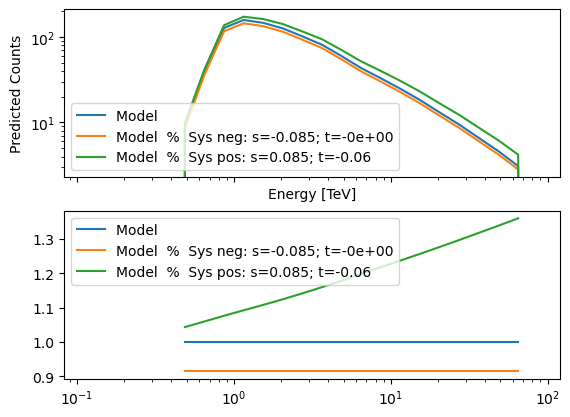

In [13]:
fig,ax = plt.subplots(2,1, sharex = True)

energy_bounds = energy_bounds =(true_energy[0], true_energy[-1] ) * u.TeV

npred =     dataset_cor.npred_signal().data.sum(axis = 2).sum(axis= 1) #or (dataset_cor.counts - dataset_cor.background)
npred_neg = dataset_neg.npred_signal().data.sum(axis = 2).sum(axis= 1)
npred_pos = dataset_pos.npred_signal().data.sum(axis = 2).sum(axis= 1)


ax[0].plot(true_energy, npred, label = "Model ")
ax[0].plot(true_energy, npred_neg, 
         label =f"Model  %  Sys neg: s={shift_neg:.2}; t={tilt_neg:.1}")
ax[0].plot(true_energy, npred_pos,  
         label =f"Model  %  Sys pos: s={shift_pos:.2}; t={tilt_pos:.1}")

         
ax[0].loglog()
ax[0].legend()
ax[0].set_xlabel("Energy [TeV]")
ax[0].set_ylabel("Predicted Counts")


ax[1].plot(true_energy, npred/npred, label = "Model ")
ax[1].plot(true_energy, npred_neg/npred, 
         label =f"Model  %  Sys neg: s={shift_neg:.2}; t={tilt_neg:.1}")
ax[1].plot(true_energy, npred_pos/npred,  
         label =f"Model  %  Sys pos: s={shift_pos:.2}; t={tilt_pos:.1}")

ax[1].legend()
ax[1].set_xscale('log')
fig = plt.gcf()
fig.savefig("plots/1_counts.pdf")

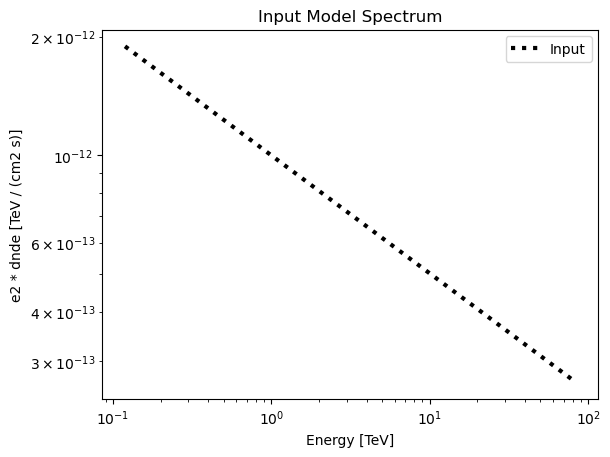

In [14]:
energy_bounds = energy_bounds =(true_energy[0], true_energy[-1] ) * u.TeV
#dataset_cor.models['Source'].spectral_model.plot(energy_bounds, label = "Spectrum")
#dataset_neg.models['Source'].spectral_model.plot(energy_bounds, label = "")
#dataset_pos.models['Source'].spectral_model.plot(energy_bounds, label = "")
dataset_asimov.models['Source'].spectral_model.plot(energy_bounds, energy_power = 2,
                                label = "Input", color = 'black', linewidth = 3, linestyle ='dotted')
plt.title("Input Model Spectrum")
plt.legend()

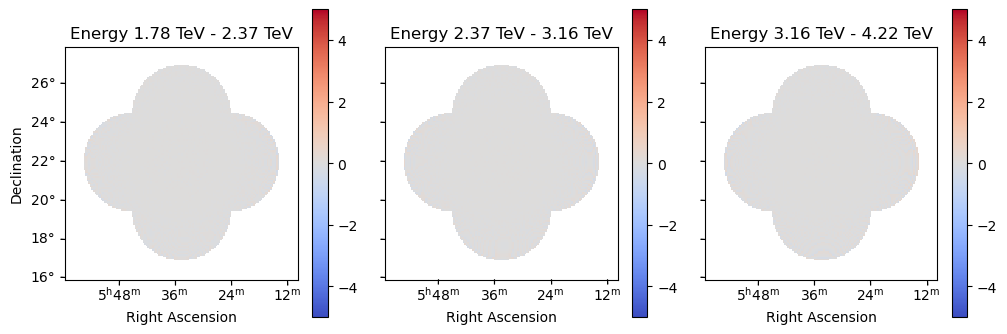

In [15]:
estimator = ExcessMapEstimator(
    correlation_radius=f"0.5 deg",
    energy_edges=dataset_cor.counts.geom.axes['energy'].edges[10:14])
result = estimator.run(dataset_cor)
result["sqrt_ts"].plot_grid(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5,);

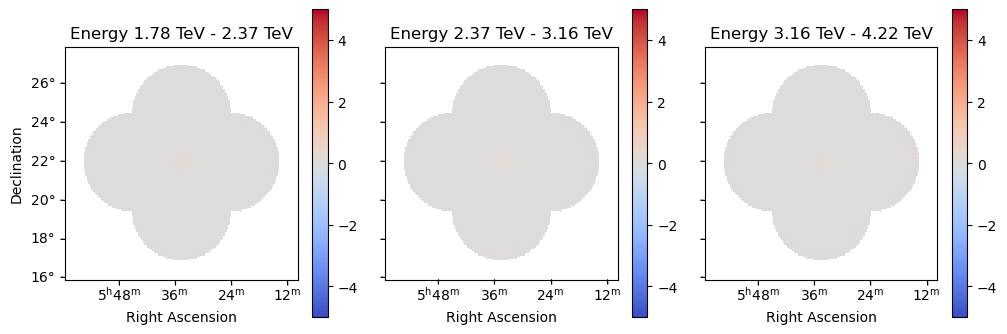

In [16]:
result = estimator.run(dataset_neg)
result["sqrt_ts"].plot_grid(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5,);

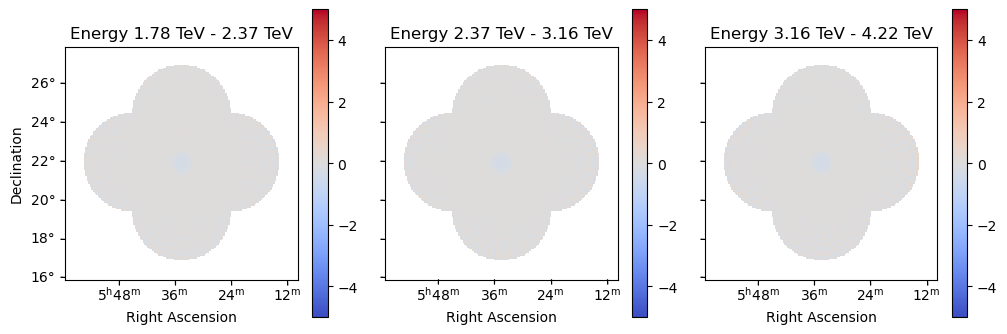

In [17]:
result = estimator.run(dataset_pos)
result["sqrt_ts"].plot_grid(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5,);

In [18]:
%%time
fit_cor = Fit(store_trace=False)
result_cor = fit_cor.run([dataset_cor])
fit_neg = Fit(store_trace=False)
result_neg = fit_neg.run([dataset_neg])
fit_pos = Fit(store_trace=False)
result_pos = fit_pos.run([dataset_pos])
print(result_pos)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 96
	total stat : -753578.91

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

CPU times: total: 3.23 s
Wall time: 3.27 s


In [19]:
datasets_short = [dataset_neg, dataset_cor, dataset_pos]
print("Best Fit amplitude")
amplitudes = []
m = dataset_asimov.models['Source']
value = m.parameters['amplitude'].value 
error = m.parameters['amplitude'].error
amplitudes.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    m = d.models['Source']
    value = m.parameters['amplitude'].value 
    error = m.parameters['amplitude'].error
    amplitudes.append((value, error))
    print(f'{value} pm {error}')
print()
print("Best Fit Index")
indices = []
m = dataset_asimov.models['Source']
value = m.parameters['index'].value 
error = m.parameters['index'].error
indices.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    m = d.models['Source']
    value = m.parameters['index'].value 
    error = m.parameters['index'].error
    indices.append((value, error))
    print(f'{value} pm {error}')
print()

print("Best Fit bkg Norm")
norms = []
value = dataset_asimov.background_model.parameters['norm'].value 
error = dataset_asimov.background_model.parameters['norm'].error
norms.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    value = d.background_model.parameters['norm'].value 
    error = d.background_model.parameters['norm'].error
    print(f'{value} pm {error}')
    norms.append((value, error))
print()   
    
#print("Best Fit Lambda")
#lambdas = []
#value = dataset_asimov.models.parameters['lambda_'].value 
#error = dataset_asimov.models.parameters['lambda_'].error
#lambdas.append((value, error))
#print('====')
#print('Input')
#print(f'{value} pm {error}')
#print('====')
#for d in datasets_short:
#    value = d.models.parameters['lambda_'].value 
#    error = d.models.parameters['lambda_'].error
#    print(f'{value} pm {error}')
#    lambdas.append((value, error))
    
    
with open('data/1_norms.yaml', 'w') as file:
    documents = yaml.dump(norms, file)
with open('data/1_amplitudes.yaml', 'w') as file:
    documents = yaml.dump(amplitudes, file)
with open('data/1_indices.yaml', 'w') as file:
    documents = yaml.dump(indices, file)
#with open('data/1_lambdas.yaml', 'w') as file:
#    documents = yaml.dump(lambdas, file)
    
dataset_neg.models.write("data/1_model_neg.yml", overwrite= True)
dataset_pos.models.write("data/1_model_pos.yml", overwrite= True)
dataset_cor.models.write("data/1_model_cor.yml", overwrite= True)

Best Fit amplitude
====
Input
1e-12 pm 0
====
1.0940675350565171e-12 pm 9.813762653326666e-14
1.0000009389450632e-12 pm 8.975944722366998e-14
9.217937276897345e-13 pm 8.270478884964409e-14

Best Fit Index
====
Input
2.3 pm 0
====
2.3007509442687004 pm 0.06175372284529459
2.3000026980317476 pm 0.06173516259834412
2.3552824008513484 pm 0.061737281767536054

Best Fit bkg Norm
====
Input
1.0 pm 0
====
1.0000272429077006 pm 0.002065970172255026
1.0000000594748193 pm 0.0020659106007336198
1.0000123635177014 pm 0.0020659413304486797



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


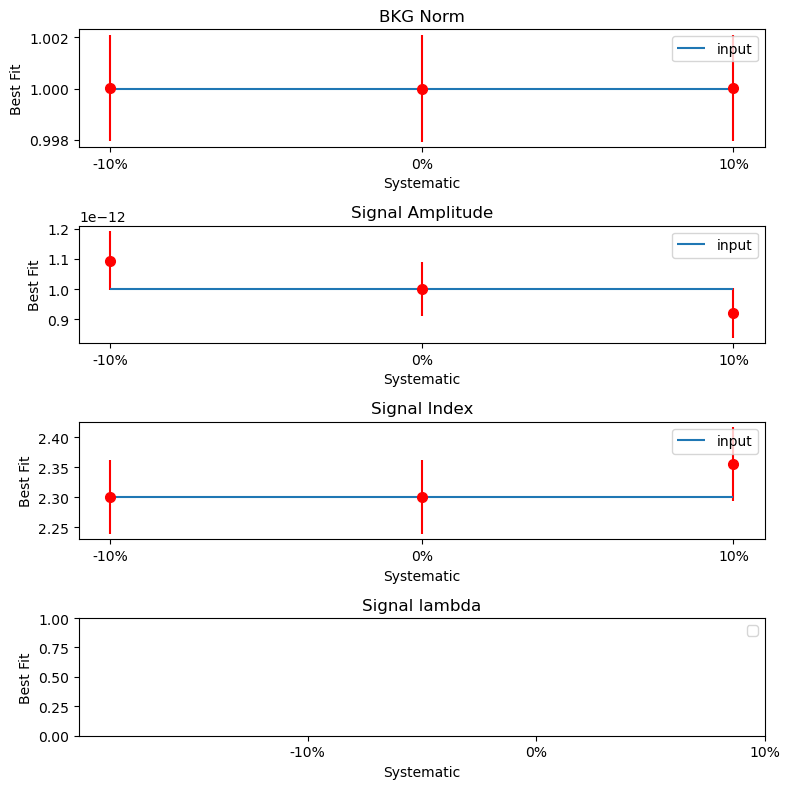

In [20]:
fig, axs = plt.subplots(4,1, figsize=(8,8))

axs[0].set_title("BKG Norm")
axs[1].set_title("Signal Amplitude")
axs[2].set_title("Signal Index")
axs[3].set_title("Signal lambda")


labels = ['-10%', '0%', '10%']

for i, a in enumerate(norms[1:]):
    axs[0].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'o', color =  'red', markersize=7)
axs[0].hlines( norms[0][0], 1, 3, label = "input")

for i, a in enumerate(amplitudes[1:]):
    axs[1].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'o', color =  'red', markersize=7)
axs[1].hlines( amplitudes[0][0], 1, 3, label = "input")

for i, a in enumerate(indices[1:]):
    axs[2].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'o', color =  'red', markersize=7)
axs[2].hlines( indices[0][0], 1, 3, label = "input")

#for i, a in enumerate(lambdas[1:]):
#    axs[3].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'o', color =  'red', markersize=7)
#axs[3].hlines( lambdas[0][0], 1, 3, label = "input")

plt.tight_layout()
for a in axs:
    a.legend(); 
    a.set_ylabel('Best Fit'); 
    a.set_xlabel('Systematic'); 
    a.set_xticks(np.arange(3)+1,labels)

plt.tight_layout()    
fig.savefig("plots/1_best_fit_parameters_standard.pdf")   


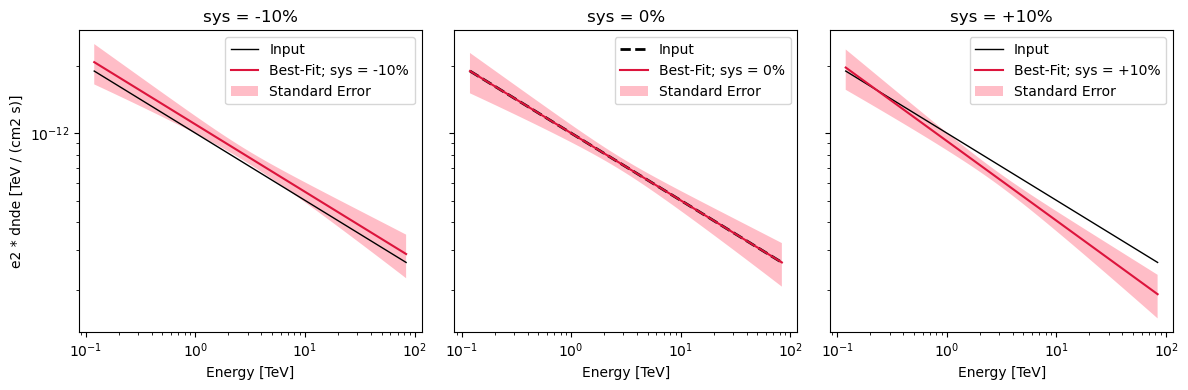

In [21]:
energy_bounds = (true_energy[0], true_energy[-1] ) * u.TeV

fig,axs = plt.subplots(1,3, sharey=True,figsize = (12,4))

for i,ax in enumerate(axs):
    if i ==1:
         dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 2, linestyle="dashed")
    else:
        dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 1, )

dataset_neg.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[0],
                                label = "Best-Fit; sys = -10%", color = "crimson")
dataset_neg.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[0],
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )

dataset_cor.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[1],
                                label = "Best-Fit; sys = 0%", color = "crimson")
dataset_cor.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[1],
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )

dataset_pos.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[2],
                                label = "Best-Fit; sys = +10%", color = "crimson")
dataset_pos.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[2],
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )
[a.legend() for a in axs]
axs[0].set_title("sys = -10%"); axs[1].set_title("sys = 0%"); axs[2].set_title("sys = +10%"); 

axs[1].set_ylabel('')
axs[2].set_ylabel('')

plt.tight_layout()
fig = plt.gcf()
fig.savefig("plots/1_spectrum_standard.pdf")

In [22]:
print(dataset_cor)

MapDataset
----------

  Name                            : ki-c419J 

  Total counts                    : 361332 
  Total background counts         : 360331.31
  Total excess counts             : 1001.66

  Predicted counts                : 361332.98
  Predicted background counts     : 360331.35
  Predicted excess counts         : 1001.63

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -753578.91

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 4

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model type       : 
    Parameters:
   

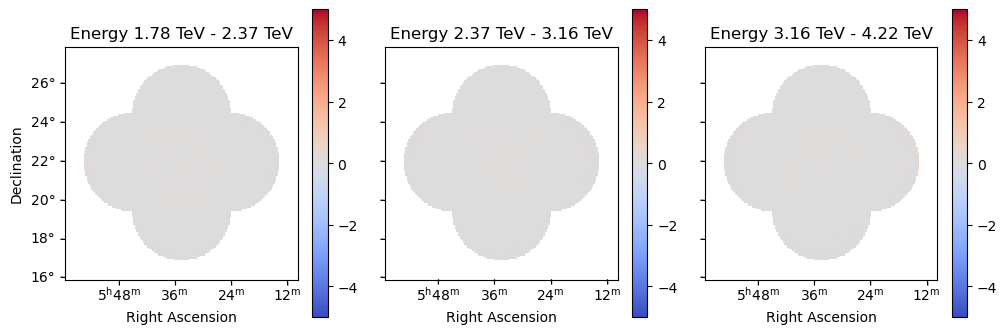

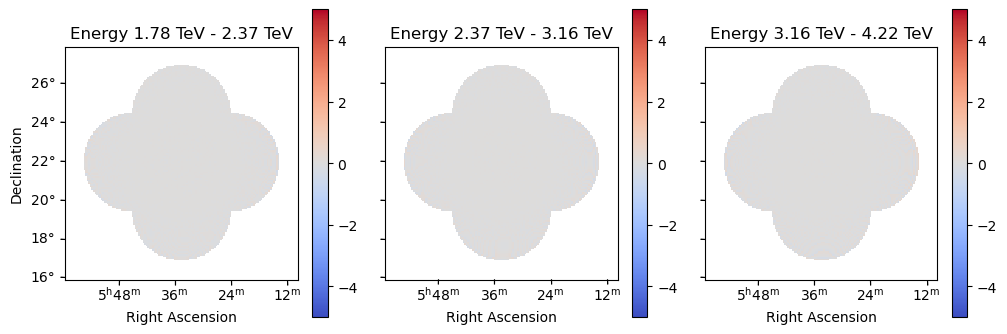

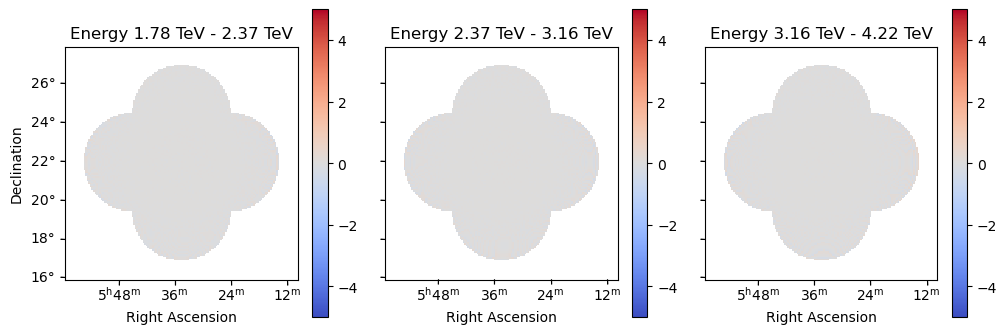

In [23]:

estimator = ExcessMapEstimator(
    correlation_radius=f"0.5 deg",
    energy_edges=dataset_cor.counts.geom.axes['energy'].edges[10:14])
result = estimator.run(dataset_cor)
result["sqrt_ts"].plot_grid(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5,);


result = estimator.run(dataset_neg)
result["sqrt_ts"].plot_grid(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5,);


result = estimator.run(dataset_pos)
result["sqrt_ts"].plot_grid(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5,);

In [24]:
%%time
errors_amplitude_shift = []
errors_index_shift = []
errors_lambda_shift = []

tilt = -0.05

for i, shift in enumerate(np.linspace(-0.11, 0.11, 45)):
    print('shift', i, '=', shift)
    sys_d = sys_dataset(dataset_asimov, shift, tilt, False)
    dataset_shift = sys_d.create_dataset()
    fit_shift = Fit(store_trace=False)
    result_shift = fit_shift.run([dataset_shift])
    errors_amplitude_shift.append((shift, dataset_shift.models.parameters['amplitude'].error))
    errors_index_shift.append((shift, dataset_shift.models.parameters['index'].error))
    #errors_lambda_shift.append((shift, dataset_shift.models.parameters['lambda_'].error))
    print(dataset_shift.models.parameters['amplitude'].error)
    print(dataset_shift.models.parameters['index'].error)

shift 0 = -0.11
1.007977045704547e-13
0.06175556862076929
shift 1 = -0.105
1.002312333147167e-13
0.061750838858640904
shift 2 = -0.1
9.969029961855678e-14
0.061755569707021604
shift 3 = -0.095
9.912214913293882e-14
0.061796159622829666
shift 4 = -0.09
9.859974629465195e-14
0.06174870903718504
shift 5 = -0.08499999999999999
9.804967052130739e-14
0.06175905721655697
shift 6 = -0.08
9.750444962504195e-14
0.06177577110116021
shift 7 = -0.075
9.700613919262061e-14
0.061778400689937375
shift 8 = -0.07
9.648933019139063e-14
0.06175459793152651
shift 9 = -0.065
9.598663480531127e-14
0.061737944489095836
shift 10 = -0.06
9.546993248135463e-14
0.06174194517236142
shift 11 = -0.055
9.496693343595204e-14
0.06174424015770219
shift 12 = -0.05
9.445551547194139e-14
0.061755703900995475
shift 13 = -0.045
9.39535418423432e-14
0.061758946563442996
shift 14 = -0.039999999999999994
9.349949366317054e-14
0.061741941780411605
shift 15 = -0.035
9.30058862733525e-14
0.06175398378932477
shift 16 = -0.03
9.2517

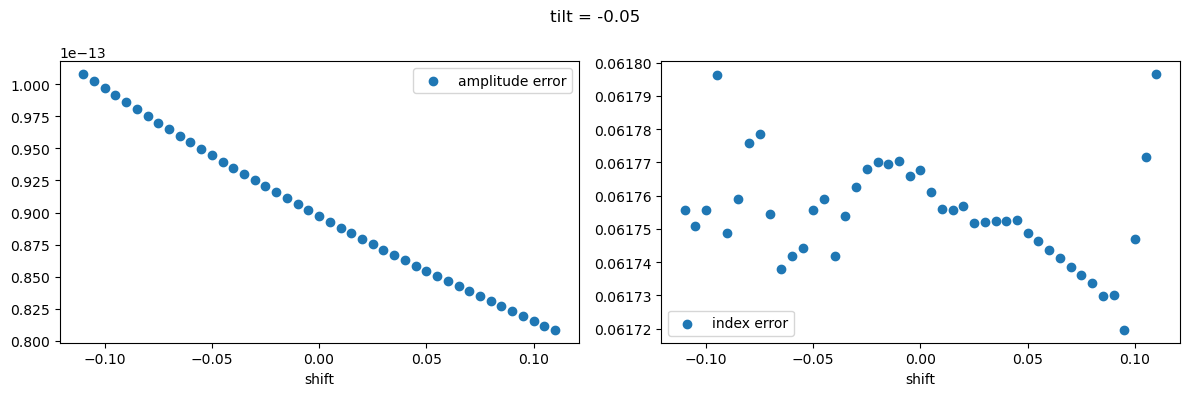

In [25]:
zip(*errors_amplitude_shift)
zip(*errors_index_shift)
zip(*errors_lambda_shift)

fig, ax = plt.subplots(1,2, figsize=(12,4))

ax[0].scatter(*zip(*errors_amplitude_shift), label='amplitude error')  
ax[1].scatter(*zip(*errors_index_shift), label='index error')
#ax[2].scatter(*zip(*errors_lambda_shift), label='lambda')
ax[0].set_xlabel('shift');ax[1].set_xlabel('shift')#;ax[2].set_xlabel('shift')
ax[0].legend();ax[1].legend()#;ax[2].legend()
plt.suptitle(f'tilt = {tilt}')
plt.tight_layout()
plt.show()

In [26]:
np.delete(np.linspace(-0.11, 0.11, 45), 6)

array([-0.11 , -0.105, -0.1  , -0.095, -0.09 , -0.085, -0.075, -0.07 ,
       -0.065, -0.06 , -0.055, -0.05 , -0.045, -0.04 , -0.035, -0.03 ,
       -0.025, -0.02 , -0.015, -0.01 , -0.005,  0.   ,  0.005,  0.01 ,
        0.015,  0.02 ,  0.025,  0.03 ,  0.035,  0.04 ,  0.045,  0.05 ,
        0.055,  0.06 ,  0.065,  0.07 ,  0.075,  0.08 ,  0.085,  0.09 ,
        0.095,  0.1  ,  0.105,  0.11 ])

In [27]:
%%time
errors_amplitude_tilt = []
errors_index_tilt = []
errors_lambda_tilt = []

shift = -0.1

for i, tilt in enumerate(np.linspace(-0.075, 0.075, 31)):
    print('tilt', i, '=', tilt)
    sys_d = sys_dataset(dataset_asimov, shift, tilt, False)
    dataset_tilt = sys_d.create_dataset()
    fit_tilt = Fit(store_trace=False)
    result_tilt = fit_tilt.run([dataset_tilt])
    errors_amplitude_tilt.append((tilt, dataset_tilt.models.parameters['amplitude'].error))
    errors_index_tilt.append((tilt, dataset_tilt.models.parameters['index'].error))
    #errors_lambda_tilt.append((tilt, dataset_tilt.models.parameters['lambda_'].error))
    print(dataset_tilt.models.parameters['amplitude'].error)
    print(dataset_tilt.models.parameters['index'].error)

tilt 0 = -0.075
9.969804921814189e-14
0.06172607727393761
tilt 1 = -0.06999999999999999
9.969506339496389e-14
0.061764558879316624
tilt 2 = -0.065
9.966130666113231e-14
0.061758935034410864
tilt 3 = -0.06
9.966984918521342e-14
0.06176024406781951
tilt 4 = -0.05499999999999999
9.969047765387814e-14
0.06174564238020032
tilt 5 = -0.049999999999999996
9.969029961855678e-14
0.061755569707021604
tilt 6 = -0.045
9.968416231741213e-14
0.0617551801026717
tilt 7 = -0.039999999999999994
9.969836618321003e-14
0.061757790363018095
tilt 8 = -0.034999999999999996
9.970976300580716e-14
0.06175796620174144
tilt 9 = -0.03
9.971899695151869e-14
0.061757792544939176
tilt 10 = -0.024999999999999994
9.972701141544996e-14
0.06175762504764598
tilt 11 = -0.019999999999999997
9.973423984253607e-14
0.061757543085991025
tilt 12 = -0.015
9.974096198825578e-14
0.0617575374200425
tilt 13 = -0.009999999999999995
9.974723614261984e-14
0.06175762959454793
tilt 14 = -0.0049999999999999906
9.975321064052394e-14
0.0617577

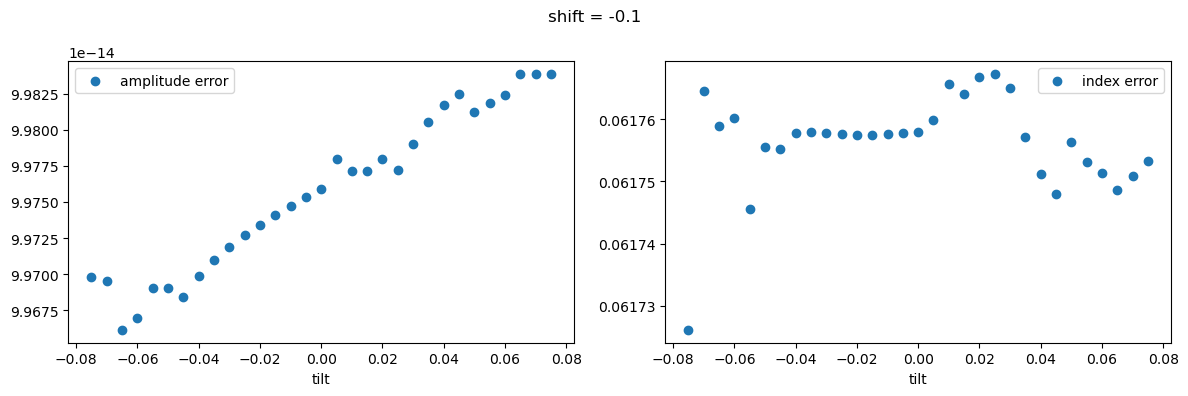

In [28]:
zip(*errors_amplitude_tilt)
zip(*errors_index_tilt)
zip(*errors_lambda_tilt)

fig, ax = plt.subplots(1,2, figsize=(12,4))

ax[0].scatter(*zip(*errors_amplitude_tilt), label='amplitude error')  
ax[1].scatter(*zip(*errors_index_tilt), label='index error')
#ax[2].scatter(*zip(*errors_lambda_tilt), label='lambda')
ax[0].set_xlabel('tilt');ax[1].set_xlabel('tilt')#;ax[2].set_xlabel('tilt')
ax[0].legend();ax[1].legend()#;ax[2].legend()
plt.suptitle(f'shift = {shift}')
plt.tight_layout()
plt.show()

In [29]:
%%time
errors_amplitude_3d = []
errors_index_3d = []
errors_lambda_3d = []
compute = True
if compute:
    for i, shift in enumerate(np.delete(np.linspace(-0.10, 0.10, 11), 1)):

        for j, tilt in enumerate(np.linspace(-0.055, 0.055, 13)):
            print(shift, tilt)
            sys_d = sys_dataset(dataset_asimov, shift, tilt, False)
            dataset_3d = sys_d.create_dataset()
            fit = Fit(store_trace=False)
            result = fit.run([dataset_3d])
            errors_amplitude_3d.append((shift, tilt, dataset_3d.models.parameters['amplitude'].error))
            #print(dataset_3d.models.parameters['amplitude'].error)
            #print(dataset_3d.models.parameters['index'].error)
            errors_index_3d.append((shift, tilt, dataset_3d.models.parameters['index'].error))
            #errors_lambda_3d.append((shift, tilt, dataset_3d.models.parameters['lambda_'].error))


-0.1 -0.055
-0.1 -0.04583333333333334
-0.1 -0.03666666666666667
-0.1 -0.0275
-0.1 -0.018333333333333333
-0.1 -0.009166666666666663
-0.1 0.0
-0.1 0.009166666666666663
-0.1 0.018333333333333333
-0.1 0.027500000000000004
-0.1 0.036666666666666674
-0.1 0.04583333333333333
-0.1 0.055
-0.060000000000000005 -0.055
-0.060000000000000005 -0.04583333333333334
-0.060000000000000005 -0.03666666666666667
-0.060000000000000005 -0.0275
-0.060000000000000005 -0.018333333333333333
-0.060000000000000005 -0.009166666666666663
-0.060000000000000005 0.0
-0.060000000000000005 0.009166666666666663
-0.060000000000000005 0.018333333333333333
-0.060000000000000005 0.027500000000000004
-0.060000000000000005 0.036666666666666674
-0.060000000000000005 0.04583333333333333
-0.060000000000000005 0.055
-0.04000000000000001 -0.055
-0.04000000000000001 -0.04583333333333334
-0.04000000000000001 -0.03666666666666667
-0.04000000000000001 -0.0275
-0.04000000000000001 -0.018333333333333333
-0.04000000000000001 -0.00916666666

In [30]:
np.linspace(-0.055, 0.055, 13)

array([-0.055     , -0.04583333, -0.03666667, -0.0275    , -0.01833333,
       -0.00916667,  0.        ,  0.00916667,  0.01833333,  0.0275    ,
        0.03666667,  0.04583333,  0.055     ])

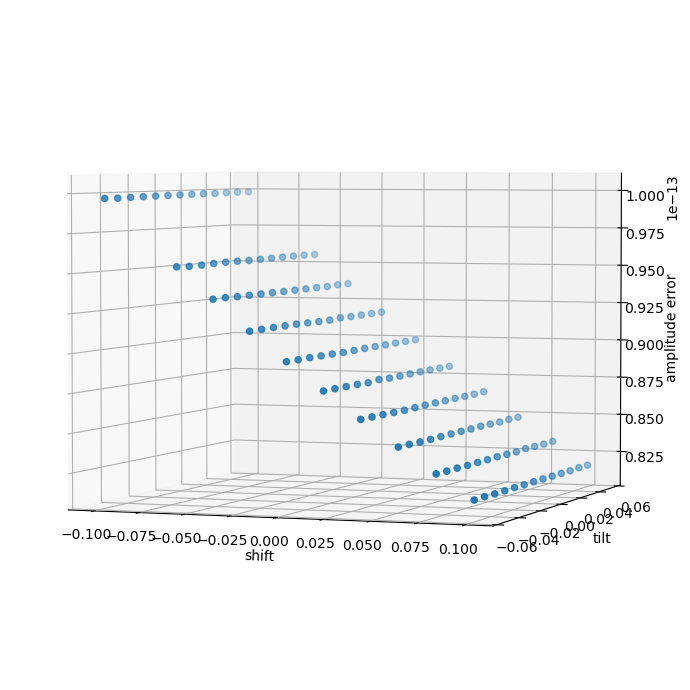

In [36]:
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection = '3d')

ax.scatter3D(*zip(*errors_amplitude_3d), label='amplitude error') 
ax.view_init(3,290)
#ax.set_zlim3d(0.8e-13, 1.01e-13)
ax.set_xlabel('shift')
ax.set_ylabel('tilt')
ax.set_zlabel('amplitude error')
plt.tight_layout()
plt.show()

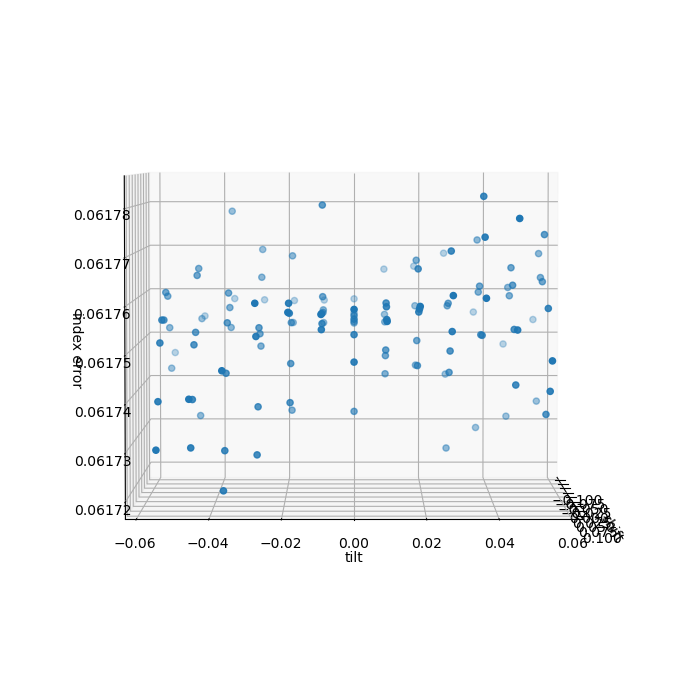

In [32]:
fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection='3d')

ax.scatter3D(*zip(*errors_index_3d), label='index error') 
ax.view_init(3,0)
#ax.set_zlim3d(0.057,0.066)
ax.set_xlabel('shift')
ax.set_ylabel('tilt')
ax.set_zlabel('index error')
plt.tight_layout()
plt.show()